# NET 4103/7431 — Homework: Network Science and Graph Learning

Notebook pour réaliser l'ensemble des questions du devoir à partir des réseaux Facebook100 (fichiers `.gml`) placés dans le dossier `data/`.

**Organisation attendue:**
- Vos réponses (figures + texte) dans un PDF/DOCX
- Votre code dans un dépôt GitHub classroom
- Ce notebook sert de base pour produire vos figures et vos métriques

## 0) Configuration et imports

Ce notebook suppose la présence d'un sous-dossier `data/` contenant les fichiers Facebook100 au format `.gml`:

```
.
├── notebook_net_homework.ipynb
└── data/
    ├── American75.gml
    ├── Caltech36.gml
    ├── MIT8.gml
    ├── Johns Hopkins55.gml
    └── (autres réseaux FB100)
```

### Packages requis
```bash
pip install networkx numpy pandas matplotlib scipy scikit-learn tqdm torch
```

In [1]:
# Imports standards
import os
from pathlib import Path
import math
import random

# Calcul numérique
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Analyse de réseaux
import networkx as nx

# Statistiques
from scipy import sparse
from scipy.stats import spearmanr

# Barre de progression
from tqdm.auto import tqdm

# Machine learning
from sklearn.metrics import accuracy_score, f1_score, normalized_mutual_info_score, adjusted_rand_score

# Deep learning (pour label propagation)
import torch

print("Tous les packages ont été importés avec succès")

Tous les packages ont été importés avec succès


## 1) Chargement des graphes Facebook100

Les fichiers `.gml` contiennent:
- La structure du réseau (arêtes)
- Les attributs des nœuds (status, gender, major, dorm, year, etc.)

On charge les graphes comme graphes **simples**, **non orientés**, sans boucles, puis on garde la **plus grande composante connexe (LCC)** comme demandé dans l'énoncé.

In [2]:
def load_graph(path: str | Path) -> nx.Graph:
    """
    Charge un graphe depuis un fichier .gml (Facebook100).
    Retourne un graphe NetworkX simple non orienté, avec attributs.
    """
    path = Path(path)
    ext = path.suffix.lower()

    if ext == ".gml":
        G = nx.read_gml(path, label='id')
        G = nx.convert_node_labels_to_integers(G, ordering="sorted")
        if not isinstance(G, nx.Graph):
            G = nx.Graph(G)
    elif ext in [".graphml", ".xml"]:
        G = nx.read_graphml(path)
        G = nx.convert_node_labels_to_integers(G, ordering="sorted")
        if not isinstance(G, nx.Graph):
            G = nx.Graph(G)
    elif ext in [".txt", ".edgelist", ".csv"]:
        G = nx.read_edgelist(path, nodetype=int)
        if not isinstance(G, nx.Graph):
            G = nx.Graph(G)
    else:
        raise ValueError(f"Extension non supportée: {ext}")

    # Nettoyage: simple, non orienté, sans boucles
    G = nx.Graph(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G


def largest_connected_component(G: nx.Graph) -> nx.Graph:
    """Retourne la plus grande composante connexe du graphe"""
    if G.number_of_nodes() == 0:
        return G.copy()
    if nx.is_connected(G):
        return G.copy()
    lcc_nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(lcc_nodes).copy()


# Définir le répertoire des données
DATA_DIR = Path("data")
if not DATA_DIR.exists():
    print(f"Attention: le dossier {DATA_DIR} n'existe pas. Création...")
    DATA_DIR.mkdir(exist_ok=True)
else:
    print(f"Dossier {DATA_DIR} trouvé")

Dossier data trouvé


### 1.1) Lister et charger les graphes Facebook100

In [3]:
def list_graph_files(data_dir=DATA_DIR):
    """Liste tous les fichiers .gml dans le dossier data/"""
    exts = {".gml", ".graphml", ".xml", ".edgelist", ".txt", ".csv"}
    files = [p for p in Path(data_dir).glob("*") if p.suffix.lower() in exts]
    return sorted(files)

graph_files = list_graph_files()
print(f"Nombre de fichiers trouvés: {len(graph_files)}")
if len(graph_files) > 0:
    print(f"Exemples: {[f.name for f in graph_files[:5]]}")

Nombre de fichiers trouvés: 100
Exemples: ['American75.gml', 'Amherst41.gml', 'Auburn71.gml', 'Baylor93.gml', 'BC17.gml']


In [4]:
# Charger tous les graphes (LCC) du dossier data/
print("Chargement des réseaux Facebook100...")
print(f"{'Fichier':<30} {'Nœuds':>8} {'Arêtes':>10}")
print("-" * 50)

graphs = {}
for fp in tqdm(graph_files, desc="Chargement"):
    try:
        G = load_graph(fp)
        Glcc = largest_connected_component(G)
        graphs[fp.stem] = Glcc
        print(f"{fp.name:<30} {Glcc.number_of_nodes():>8,} {Glcc.number_of_edges():>10,}")
    except Exception as e:
        print(f"[ERREUR] {fp.name}: {e}")

print(f"\nTotal: {len(graphs)} réseaux chargés avec succès")

# Choisir un graphe par défaut (American75 comme dans l'exemple fourni)
default_graph_name = "American75" if "American75" in graphs else next(iter(graphs), None)
print(f"Graphe par défaut: {default_graph_name}")

Chargement des réseaux Facebook100...
Fichier                           Nœuds     Arêtes
--------------------------------------------------


Chargement:   0%|          | 0/100 [00:00<?, ?it/s]

American75.gml                    6,370    217,654
Amherst41.gml                     2,235     90,954
Amherst41.gml                     2,235     90,954
Auburn71.gml                     18,448    973,918
Auburn71.gml                     18,448    973,918
Baylor93.gml                     12,799    679,815
Baylor93.gml                     12,799    679,815
BC17.gml                         11,498    486,961
BC17.gml                         11,498    486,961
Berkeley13.gml                   22,900    852,419
Berkeley13.gml                   22,900    852,419
Bingham82.gml                    10,001    362,892
Bingham82.gml                    10,001    362,892
Bowdoin47.gml                     2,250     84,386
Bowdoin47.gml                     2,250     84,386
Brandeis99.gml                    3,887    137,561
Brandeis99.gml                    3,887    137,561
Brown11.gml                       8,586    384,519
Brown11.gml                       8,586    384,519
BU10.gml                       

In [ ]:
# ============================================================
# Q1 — Statistiques globales des réseaux Facebook100
# Inspiré de Traud et al. (2010) et Ugander et al. (2015)
# ============================================================

def global_network_statistics(G: nx.Graph) -> dict:
    """
    Calcule les statistiques globales standards pour Q1.
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()
    avg_deg = 2 * m / n
    density = nx.density(G)
    transitivity = nx.transitivity(G)
    clustering_mean = np.mean(list(nx.clustering(G).values()))
    assortativity = nx.degree_assortativity_coefficient(G)

    return {
        "n": n,
        "m": m,
        "degré_moyen": avg_deg,
        "densité": density,
        "clustering_global": transitivity,
        "clustering_local_moyen": clustering_mean,
        "assortativité_degré": assortativity
    }

# Réseaux étudiés (Q1 typiquement = comparaison)
networks_q1 = ["Caltech36", "MIT8", "Johns Hopkins55"]

rows = []
for name in networks_q1:
    if name in graphs:
        stats = global_network_statistics(graphs[name])
        stats["réseau"] = name
        rows.append(stats)

df_q1 = (
    pd.DataFrame(rows)
    .set_index("réseau")
    .sort_values("n")
)

print("Statistiques globales")
display(df_q1)


Statistiques globales — Question 1


,n,m,degré_moyen,densité,clustering_global,clustering_local_moyen,assortativité_degré
réseau,,,,,,,
Caltech36,762,16651,43.703412,0.057429,0.291281,0.409117,-0.066171
Johns Hopkins55,5157,186572,72.356797,0.014034,0.193161,0.269008,0.079671
MIT8,6402,251230,78.484848,0.012261,0.180288,0.272360,0.119896


## 2) Question 2 — Analyse des réseaux sociaux (degré, clustering, densité)

L'énoncé demande spécifiquement **Caltech36**, **MIT8** et **Johns Hopkins55**.
Ces trois universités représentent des réseaux de tailles différentes.

In [5]:
# Sélection des 3 réseaux pour Q2
names_q2 = ["Caltech36", "MIT8", "Johns Hopkins55"]

selected = {name: graphs[name] for name in names_q2 if name in graphs}
missing = [name for name in names_q2 if name not in graphs]

if missing:
    print(f"Attention: réseaux manquants: {missing}")
else:
    print(f"✓ Tous les réseaux demandés sont disponibles")
    
print(f"\nRéseaux sélectionnés pour l'analyse:")
for name, G in selected.items():
    print(f"  - {name}: {G.number_of_nodes()} nœuds, {G.number_of_edges()} arêtes")

✓ Tous les réseaux demandés sont disponibles

Réseaux sélectionnés pour l'analyse:
  - Caltech36: 762 nœuds, 16651 arêtes
  - MIT8: 6402 nœuds, 251230 arêtes
  - Johns Hopkins55: 5157 nœuds, 186572 arêtes


### 2(a) Distribution des degrés

On trace:
- Histogramme des degrés (échelle linéaire)
- CCDF (Complementary Cumulative Distribution Function) en log-log

La CCDF montre P(K ≥ k), utile pour identifier les distributions à queue lourde typiques des réseaux sociaux.

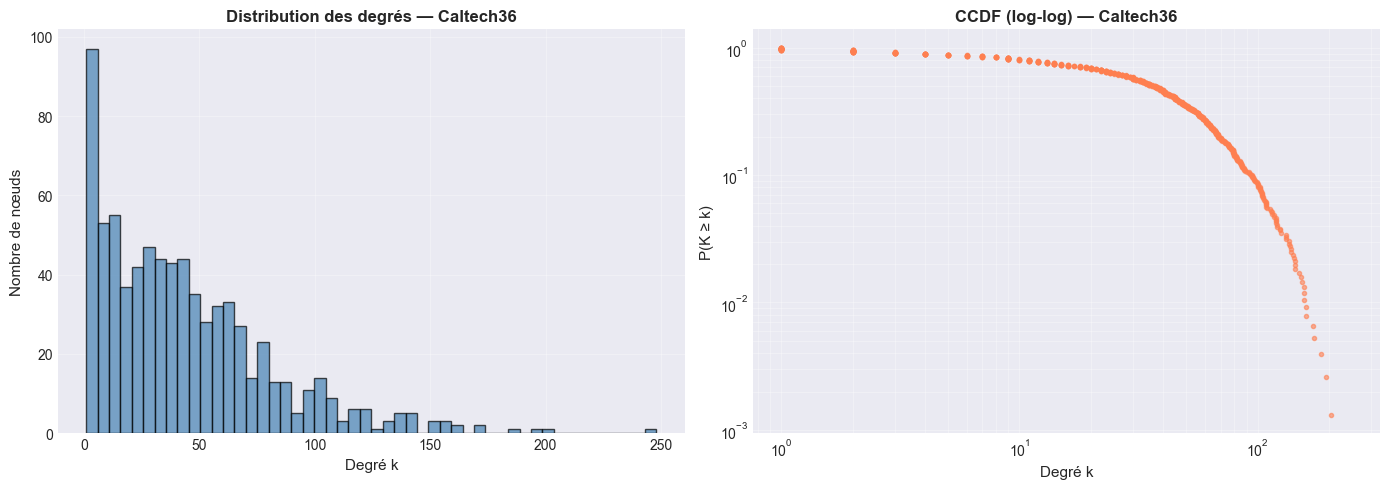


Caltech36:
  Degré moyen: 43.70
  Degré médian: 37
  Degré max: 248
  Écart-type: 36.96


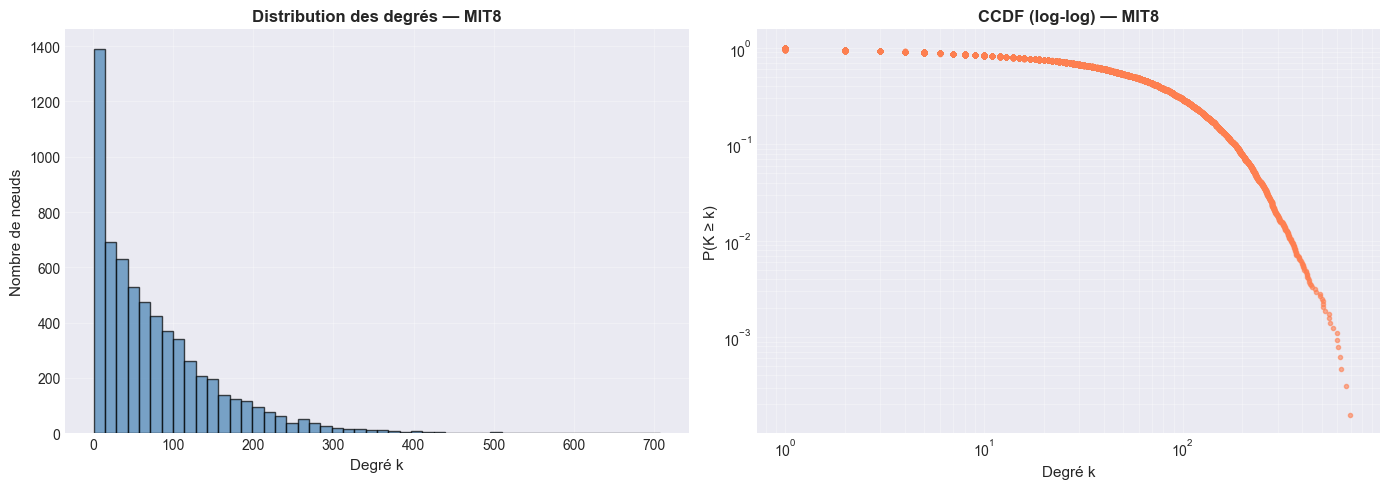


MIT8:
  Degré moyen: 78.48
  Degré médian: 56
  Degré max: 708
  Écart-type: 79.01


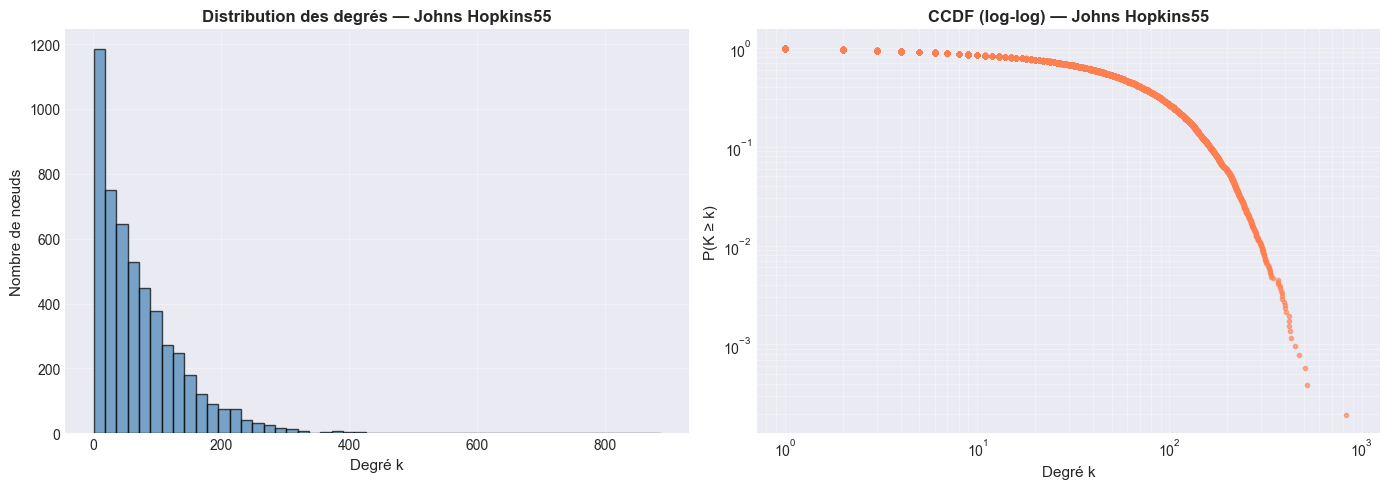


Johns Hopkins55:
  Degré moyen: 72.36
  Degré médian: 54
  Degré max: 886
  Écart-type: 69.01


In [ ]:
def degree_array(G: nx.Graph):
    """Retourne le tableau des degrés (strictement positifs pour le log-log)."""
    return np.array([d for _, d in G.degree() if d > 0], dtype=int)


def plot_degree_ccdf_comparison(graphs_dict):
    """
    Trace les CCDF des degrés en log-log pour plusieurs graphes
    sur une même figure (comparaison directe).
    """
    plt.figure(figsize=(8, 6))

    for name, G in graphs_dict.items():
        deg = degree_array(G)
        k = np.sort(deg)
        ccdf = 1.0 - np.arange(1, len(k) + 1) / len(k)

        plt.plot(
            k,
            ccdf,
            marker="o",
            linestyle="none",
            markersize=3,
            alpha=0.6,
            label=name,
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degré k (log)", fontsize=11)
    plt.ylabel("P(K ≥ k) (log)", fontsize=11)
    plt.title("Comparaison des CCDF des degrés", fontsize=12, fontweight="bold")
    plt.grid(alpha=0.3, which="both")
    plt.legend()
    plt.tight_layout()
    plt.show()


def print_degree_statistics(G: nx.Graph, name: str):
    """Affiche des statistiques descriptives simples sur les degrés."""
    deg = degree_array(G)

    print(f"\n{name}:")
    print(f"  Degré moyen   : {np.mean(deg):.2f}")
    print(f"  Degré médian  : {np.median(deg):.0f}")
    print(f"  Degré max     : {np.max(deg)}")
    print(f"  Écart-type    : {np.std(deg):.2f}")


# --- Comparaison directe des distributions de degré (Q2)
plot_degree_ccdf_comparison(selected)

# --- Statistiques descriptives par réseau
for name, G in selected.items():
    print_degree_statistics(G, name)


### 2(b) Clustering global, clustering local moyen et densité

- **Clustering global** (transitivity): 3 × (triangles) / (triplets connectés)
- **Clustering local moyen**: moyenne des coefficients de clustering locaux
- **Densité**: 2m / (n(n−1)) pour un graphe non orienté simple

In [ ]:
def clustering_and_density(G: nx.Graph) -> dict:
    """
    Calcule les métriques globales du réseau :
    - nombre de nœuds et d'arêtes
    - densité
    - clustering global (transitivity)
    - clustering local moyen
    """
    return {
        "n": G.number_of_nodes(),
        "m": G.number_of_edges(),
        "densité": nx.density(G),
        "clustering_global": nx.transitivity(G),
        "clustering_local_moyen": np.mean(list(nx.clustering(G).values()))
    }


print("Calcul des métriques de clustering et de densité...\n")

rows = []
for name, G in selected.items():
    rows.append({
        "réseau": name,
        **clustering_and_density(G)
    })

df_q2b = (
    pd.DataFrame(rows)
      .set_index("réseau")
      .sort_values("n")
)

display(df_q2b.round(4))

Calcul des métriques de clustering et densité...

Traitement de Caltech36...
Traitement de MIT8...
Traitement de MIT8...
Traitement de Johns Hopkins55...
Traitement de Johns Hopkins55...

Résultats:
                    n       m   densité  clustering_global  clustering_local_moyen
réseau                                                                            
Caltech36         762   16651  0.057429           0.291281                0.409117
Johns Hopkins55  5157  186572  0.014034           0.193161                0.269008
MIT8             6402  251230  0.012261           0.180288                0.272360

Résultats:
                    n       m   densité  clustering_global  clustering_local_moyen
réseau                                                                            
Caltech36         762   16651  0.057429           0.291281                0.409117
Johns Hopkins55  5157  186572  0.014034           0.193161                0.269008
MIT8             6402  251230  0.012261   

### 2(c) Relation degré vs clustering local

Dans les réseaux sociaux, on observe souvent une relation inverse: les nœuds de haut degré ont un clustering local plus faible (moins probable que tous leurs voisins soient connectés entre eux).


Analyse de la relation degré vs clustering local:



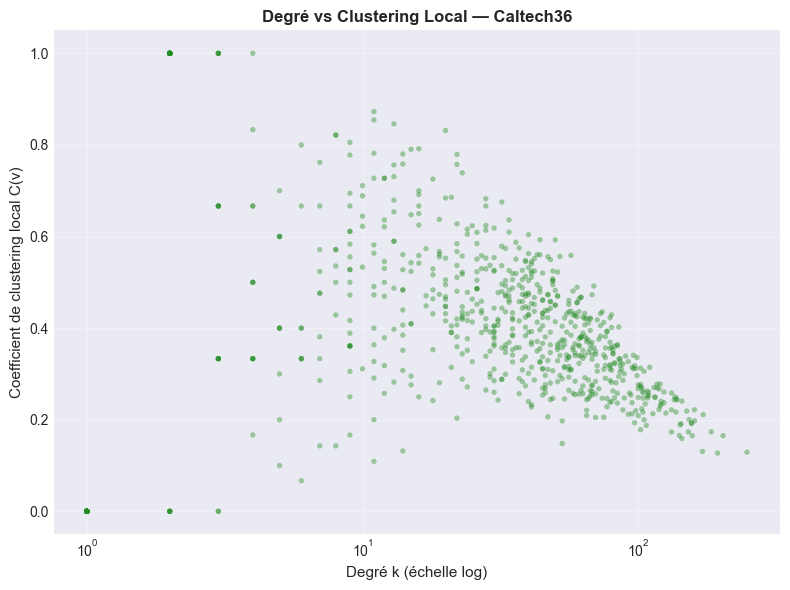

Caltech36: Corrélation de Spearman = -0.389 (p-value = 5.33e-29)


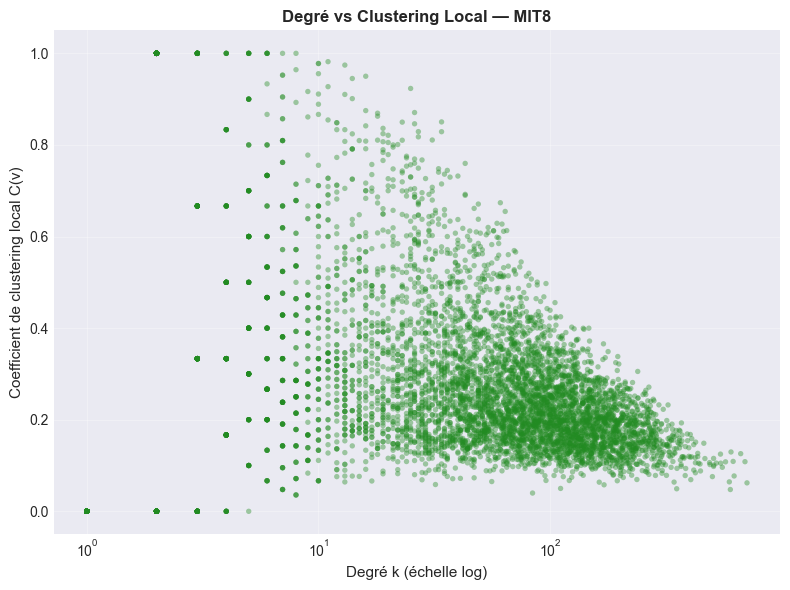

MIT8: Corrélation de Spearman = -0.246 (p-value = 7.73e-89)


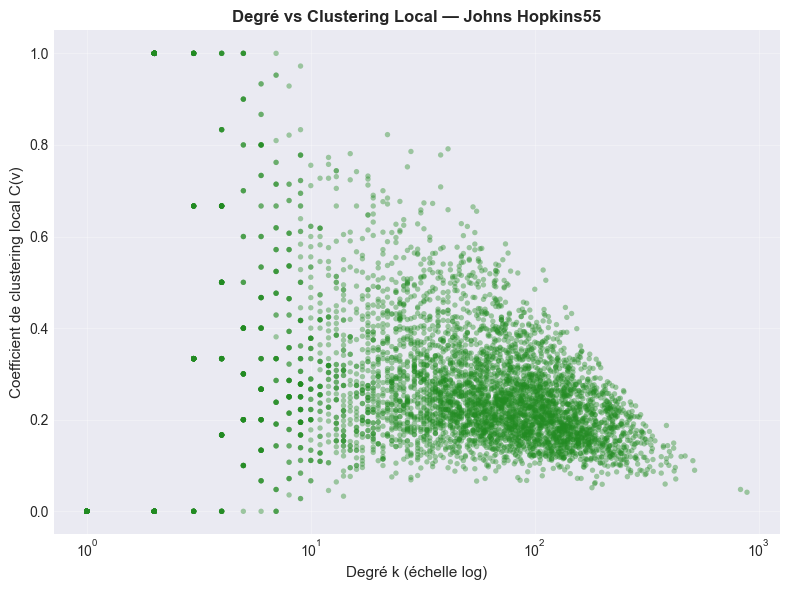

Johns Hopkins55: Corrélation de Spearman = -0.219 (p-value = 4.56e-57)


In [ ]:
def plot_degree_vs_clustering_binned(G: nx.Graph, title: str, bins=12):
    """
    Analyse de la relation degré – clustering local.
    Les degrés sont regroupés par quantiles afin de lisser le bruit.
    """
    deg = dict(G.degree())
    cl = nx.clustering(G)

    # Filtrage des degrés strictement positifs
    data = [
        (deg[v], cl[v])
        for v in G.nodes()
        if deg[v] > 0
    ]

    df = pd.DataFrame(data, columns=["k", "C"])

    # Binning par quantiles (robuste aux distributions à queue lourde)
    df["k_bin"] = pd.qcut(df["k"], q=bins, duplicates="drop")

    grouped = df.groupby("k_bin").mean()

    fig, ax = plt.subplots(figsize=(8, 6))

    # Nuage de points (bruit)
    ax.scatter(
        df["k"], df["C"],
        s=10, alpha=0.25,
        color="gray",
        label="Nœuds"
    )

    # Tendance moyenne
    ax.plot(
        grouped["k"],
        grouped["C"],
        color="crimson",
        marker="o",
        linewidth=2,
        label="Moyenne par classe"
    )

    ax.set_xscale("log")
    ax.set_xlabel("Degré k (échelle log)", fontsize=11)
    ax.set_ylabel("Clustering local moyen", fontsize=11)
    ax.set_title(f"Relation degré–clustering — {title}", fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


# Application aux réseaux étudiés
for name, G in selected.items():
    plot_degree_vs_clustering_binned(G, name)


## 3) Question 3 — Assortativité (homophilie)

On calcule l'assortativité pour 5 attributs demandés:
1. **status** (student/faculty status)
2. **major** (discipline principale)
3. **degree** (degré des nœuds)
4. **dorm** (résidence)
5. **gender** (genre)

Pour chaque attribut, on analyse:
- Scatter: assortativité vs taille du réseau (échelle log)
- Distribution des valeurs d'assortativité
- Ligne de référence y=0 (pas d'assortativité)

**Note:** L'assortativité mesure la tendance des nœuds similaires à se connecter entre eux (homophilie).

Calcul de l'assortativité pour tous les réseaux...

Traitement de l'attribut 'status'...
  → 0 réseaux avec données utilisables

Traitement de l'attribut 'major'...
  → 0 réseaux avec données utilisables

Traitement de l'attribut 'major'...
  → 0 réseaux avec données utilisables

Traitement de l'attribut 'degree'...
  → 0 réseaux avec données utilisables

Traitement de l'attribut 'degree'...
  → 100 réseaux avec données utilisables

Traitement de l'attribut 'dorm'...
  → 100 réseaux avec données utilisables

Traitement de l'attribut 'dorm'...
  → 100 réseaux avec données utilisables

Traitement de l'attribut 'gender'...
  → 100 réseaux avec données utilisables

Traitement de l'attribut 'gender'...
  → 100 réseaux avec données utilisables

Visualisation des résultats
Aucune valeur d'assortativité calculable pour 'status'.
Aucune valeur d'assortativité calculable pour 'major'.
  → 100 réseaux avec données utilisables

Visualisation des résultats
Aucune valeur d'assortativité calculable p

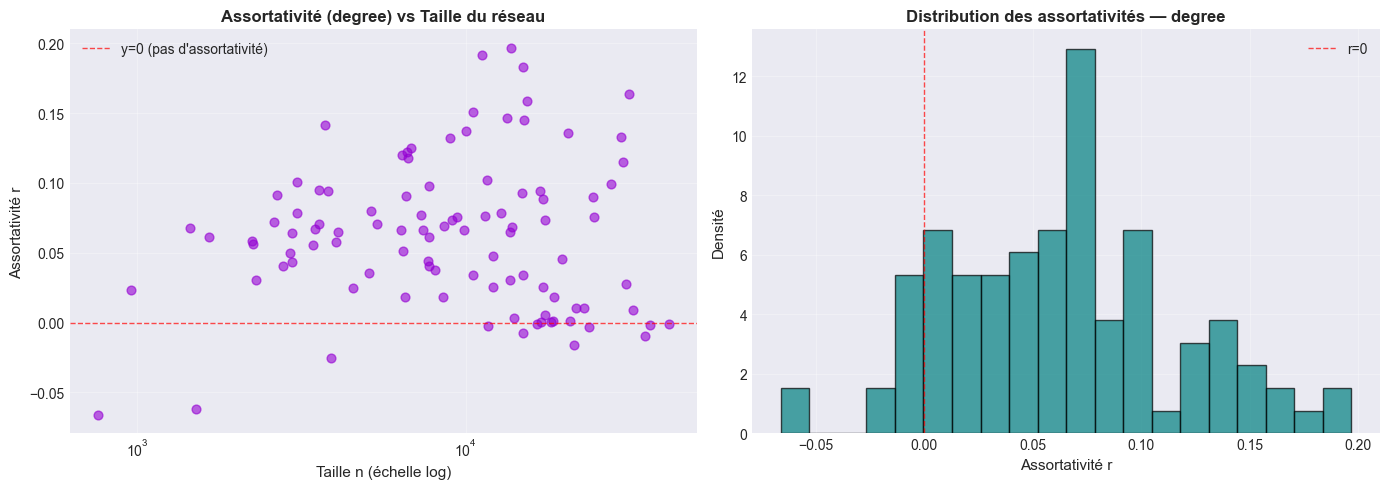


degree:
  Moyenne: 0.063
  Médiane: 0.065
  Min: -0.066, Max: 0.197


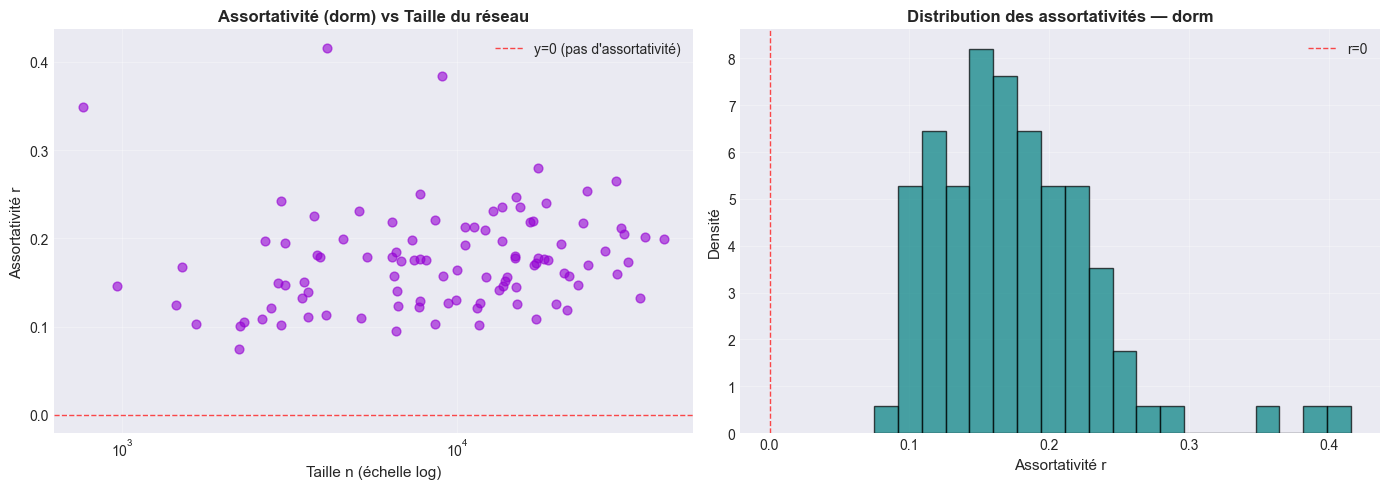


dorm:
  Moyenne: 0.175
  Médiane: 0.173
  Min: 0.075, Max: 0.416


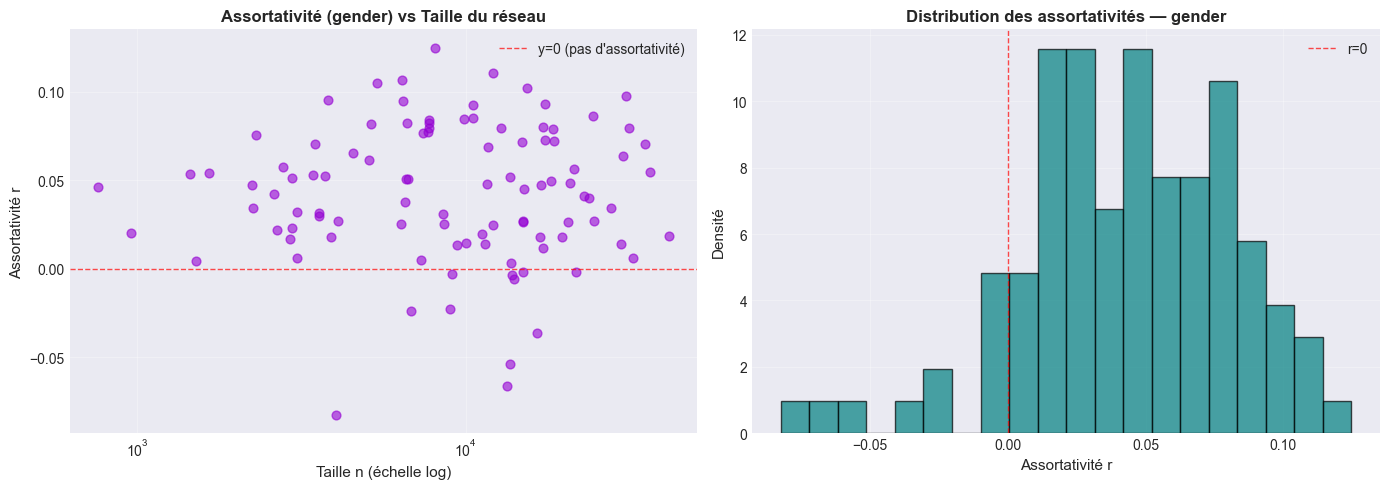


gender:
  Moyenne: 0.043
  Médiane: 0.047
  Min: -0.082, Max: 0.125


In [9]:
def graph_assortativity(G: nx.Graph, attribute: str) -> float | None:
    """Calcule l'assortativité pour un attribut donné"""
    if attribute == "degree":
        try:
            return nx.degree_assortativity_coefficient(G)
        except Exception:
            return None

    attrs = nx.get_node_attributes(G, attribute)
    if len(attrs) == 0:
        return None

    nodes_ok = [v for v in G.nodes() if v in attrs]
    if len(nodes_ok) < 10:
        return None
    H = G.subgraph(nodes_ok).copy()
    if H.number_of_edges() == 0:
        return None

    try:
        return nx.attribute_assortativity_coefficient(H, attribute)
    except Exception:
        return None


def compute_assortativity_over_graphs(graphs: dict[str, nx.Graph], attribute: str) -> pd.DataFrame:
    """Calcule l'assortativité pour tous les graphes"""
    rows = []
    for name, G in graphs.items():
        r = graph_assortativity(G, attribute)
        if r is None or np.isnan(r):
            continue
        rows.append({"graphe": name, "n": G.number_of_nodes(), "assortativité": float(r)})
    if not rows:
        return pd.DataFrame(columns=["graphe","n","assortativité"])
    return pd.DataFrame(rows).sort_values("n")


def plot_assortativity(df: pd.DataFrame, attribute: str):
    """Visualise l'assortativité pour un attribut"""
    if df.empty:
        print(f"Aucune valeur d'assortativité calculable pour '{attribute}'.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter: assortativité vs taille
    axes[0].scatter(df["n"], df["assortativité"], s=40, alpha=0.6, color='darkviolet')
    axes[0].axhline(0.0, linestyle="--", color='red', linewidth=1, alpha=0.7, label='y=0 (pas d\'assortativité)')
    axes[0].set_xscale("log")
    axes[0].set_title(f"Assortativité ({attribute}) vs Taille du réseau", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Taille n (échelle log)", fontsize=11)
    axes[0].set_ylabel("Assortativité r", fontsize=11)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Histogramme de la distribution
    axes[1].hist(df["assortativité"], bins=20, density=True, edgecolor='black', alpha=0.7, color='teal')
    axes[1].axvline(0.0, linestyle="--", color='red', linewidth=1, alpha=0.7, label='r=0')
    axes[1].set_title(f"Distribution des assortativités — {attribute}", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Assortativité r", fontsize=11)
    axes[1].set_ylabel("Densité", fontsize=11)
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{attribute}:")
    print(f"  Moyenne: {df['assortativité'].mean():.3f}")
    print(f"  Médiane: {df['assortativité'].median():.3f}")
    print(f"  Min: {df['assortativité'].min():.3f}, Max: {df['assortativité'].max():.3f}")


# Calcul pour les 5 attributs demandés
attributes = ["status", "major", "degree", "dorm", "gender"]
assort_results = {}

print("Calcul de l'assortativité pour tous les réseaux...")
for attr in attributes:
    print(f"\nTraitement de l'attribut '{attr}'...")
    df_attr = compute_assortativity_over_graphs(graphs, attr)
    assort_results[attr] = df_attr
    print(f"  → {len(df_attr)} réseaux avec données utilisables")

print("\n" + "="*60)
print("Visualisation des résultats")
print("="*60)

for attr in attributes:
    plot_assortativity(assort_results[attr], attr)

## 4) Question 4 — Link Prediction

Implémentation **sans utiliser les fonctions NetworkX** de trois métriques:
- **Common Neighbors**: nombre de voisins communs
- **Jaccard**: |N(u) ∩ N(v)| / |N(u) ∪ N(v)|
- **Adamic/Adar**: Σ(1/log(|N(w)|)) pour w ∈ N(u) ∩ N(v)

**Protocole d'évaluation:**
1. Retirer aléatoirement une fraction f d'arêtes (f ∈ {0.05, 0.1, 0.15, 0.2})
2. Scorer les paires candidates et trier par score décroissant
3. Évaluer les top-k prédictions (k ∈ {50, 100, 200, 300, 400})
4. Calculer precision@k et recall@k

**Optimisation:** On ne considère que les paires ayant au moins un voisin commun (sinon score = 0).

In [10]:
from abc import ABC, abstractmethod

class LinkPrediction(ABC):
    def __init__(self, graph: nx.Graph):
        self.graph = graph
        self.N = graph.number_of_nodes()
        self._nbrs = {u: set(graph.neighbors(u)) for u in graph.nodes()}

    def neighbors(self, v):
        return self._nbrs[v]

    @abstractmethod
    def fit(self):
        raise NotImplementedError

    @abstractmethod
    def score(self, u, v) -> float:
        raise NotImplementedError


class CommonNeighbors(LinkPrediction):
    def fit(self):
        return self

    def score(self, u, v) -> float:
        return float(len(self.neighbors(u) & self.neighbors(v)))


class Jaccard(LinkPrediction):
    def fit(self):
        return self

    def score(self, u, v) -> float:
        Nu = self.neighbors(u)
        Nv = self.neighbors(v)
        inter = len(Nu & Nv)
        union = len(Nu | Nv)
        return float(inter / union) if union > 0 else 0.0


class AdamicAdar(LinkPrediction):
    def fit(self):
        self._w = {}
        for w in self.graph.nodes():
            dw = len(self.neighbors(w))
            self._w[w] = 0.0 if dw <= 1 else 1.0 / math.log(dw)
        return self

    def score(self, u, v) -> float:
        common = self.neighbors(u) & self.neighbors(v)
        return float(sum(self._w[w] for w in common))


def train_test_split_edges(G: nx.Graph, frac_remove: float, seed: int = 0):
    rng = random.Random(seed)
    edges = list(G.edges())
    rng.shuffle(edges)
    k = int(frac_remove * len(edges))
    removed = set(tuple(sorted(e)) for e in edges[:k])

    G_train = G.copy()
    G_train.remove_edges_from(removed)
    return G_train, removed


def candidate_pairs_with_common_neighbor(G: nx.Graph):
    nbrs = {u: list(G.neighbors(u)) for u in G.nodes()}
    cand = set()
    for w, neigh in nbrs.items():
        if len(neigh) < 2:
            continue
        for i in range(len(neigh)):
            u = neigh[i]
            for j in range(i+1, len(neigh)):
                v = neigh[j]
                if u == v:
                    continue
                e = (u, v) if u < v else (v, u)
                if not G.has_edge(*e):
                    cand.add(e)
    return cand


def evaluate_link_predictor(G: nx.Graph, predictor_cls, frac_remove_list=(0.05,0.1,0.15,0.2), k_list=(50,100,200,300,400), seed=0):
    rows = []

    for f in frac_remove_list:
        G_train, removed = train_test_split_edges(G, f, seed=seed)

        predictor = predictor_cls(G_train).fit()
        candidates = candidate_pairs_with_common_neighbor(G_train)

        scored = []
        for (u, v) in candidates:
            s = predictor.score(u, v)
            if s > 0:
                scored.append((u, v, s))

        scored.sort(key=lambda x: x[2], reverse=True)

        for k in k_list:
            topk = scored[:k]
            pred_edges = set((min(u,v), max(u,v)) for u, v, _ in topk)
            tp = len(pred_edges & removed)
            precision = tp / k if k > 0 else 0.0
            recall = tp / len(removed) if len(removed) > 0 else 0.0
            topk_rate = precision
            rows.append({
                "metric": predictor_cls.__name__,
                "f_removed": f,
                "k": k,
                "TP": tp,
                "precision@k": precision,
                "recall@k": recall,
                "top@k_rate": topk_rate,
                "n_candidates": len(scored)
            })

    return pd.DataFrame(rows)


G_eval_name = default_graph_name
G_eval = graphs[G_eval_name] if G_eval_name is not None else None
G_eval_name, (G_eval.number_of_nodes(), G_eval.number_of_edges()) if G_eval is not None else None


('American75', (6370, 217654))

In [11]:
# Évaluation de Link Prediction sur le graphe par défaut
if G_eval is not None:
    print(f"Évaluation de Link Prediction sur {G_eval_name}")
    print(f"Graphe: {G_eval.number_of_nodes()} nœuds, {G_eval.number_of_edges()} arêtes")
    print("\nCette étape peut prendre plusieurs minutes...\n")
    
    df_cn = evaluate_link_predictor(G_eval, CommonNeighbors, seed=0)
    print("✓ Common Neighbors terminé")
    
    df_jac = evaluate_link_predictor(G_eval, Jaccard, seed=0)
    print("✓ Jaccard terminé")
    
    df_aa = evaluate_link_predictor(G_eval, AdamicAdar, seed=0)
    print("✓ Adamic/Adar terminé")

    df_lp = pd.concat([df_cn, df_jac, df_aa], ignore_index=True)
    print("\nPremiers résultats:")
    print(df_lp.head(10).to_string())
else:
    print("Aucun graphe disponible pour l'évaluation")

Évaluation de Link Prediction sur American75
Graphe: 6370 nœuds, 217654 arêtes

Cette étape peut prendre plusieurs minutes...

✓ Common Neighbors terminé
✓ Common Neighbors terminé
✓ Jaccard terminé
✓ Jaccard terminé
✓ Adamic/Adar terminé

Premiers résultats:
            metric  f_removed    k   TP  precision@k  recall@k  top@k_rate  n_candidates
0  CommonNeighbors       0.05   50   33     0.660000  0.003033    0.660000       6581000
1  CommonNeighbors       0.05  100   68     0.680000  0.006249    0.680000       6581000
2  CommonNeighbors       0.05  200  124     0.620000  0.011395    0.620000       6581000
3  CommonNeighbors       0.05  300  190     0.633333  0.017460    0.633333       6581000
4  CommonNeighbors       0.05  400  247     0.617500  0.022698    0.617500       6581000
5  CommonNeighbors       0.10   50   41     0.820000  0.001884    0.820000       6277272
6  CommonNeighbors       0.10  100   78     0.780000  0.003584    0.780000       6277272
7  CommonNeighbors       0.1

Visualisation des résultats de Link Prediction



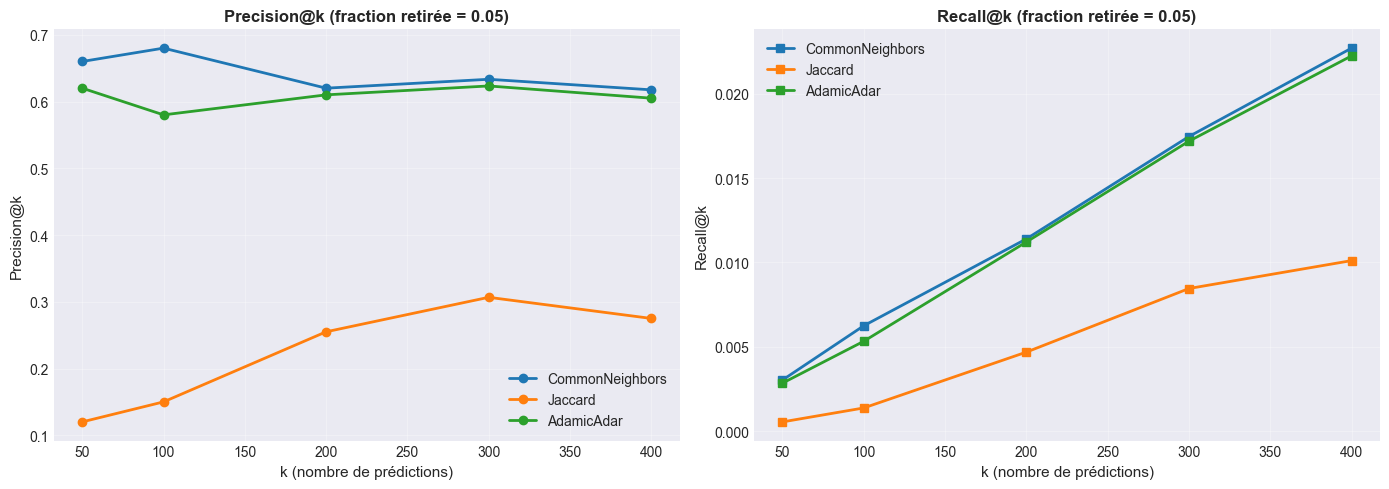

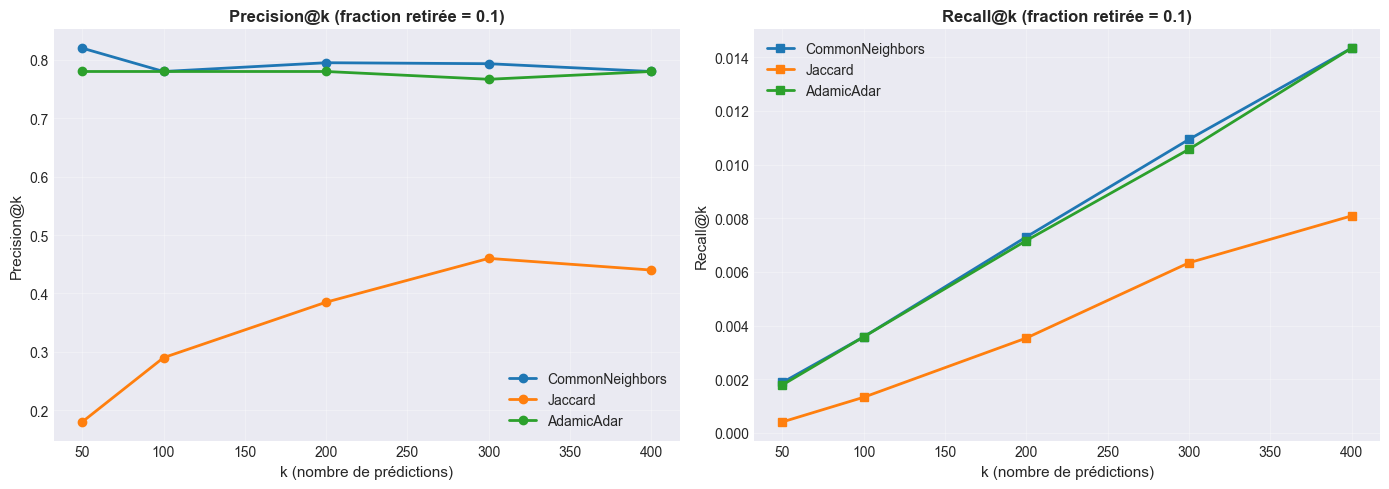

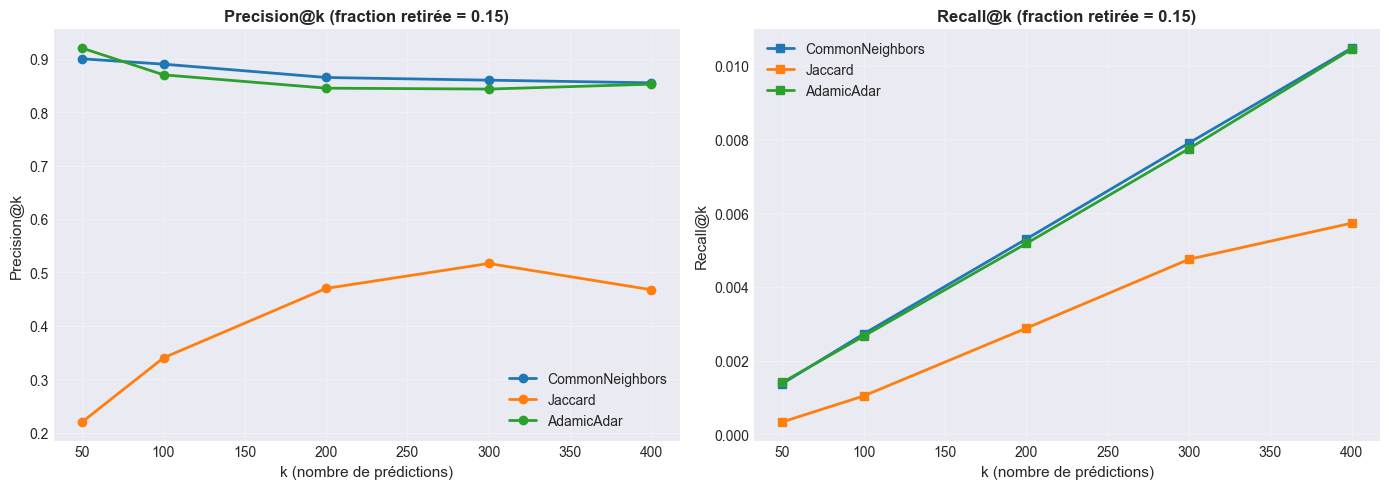

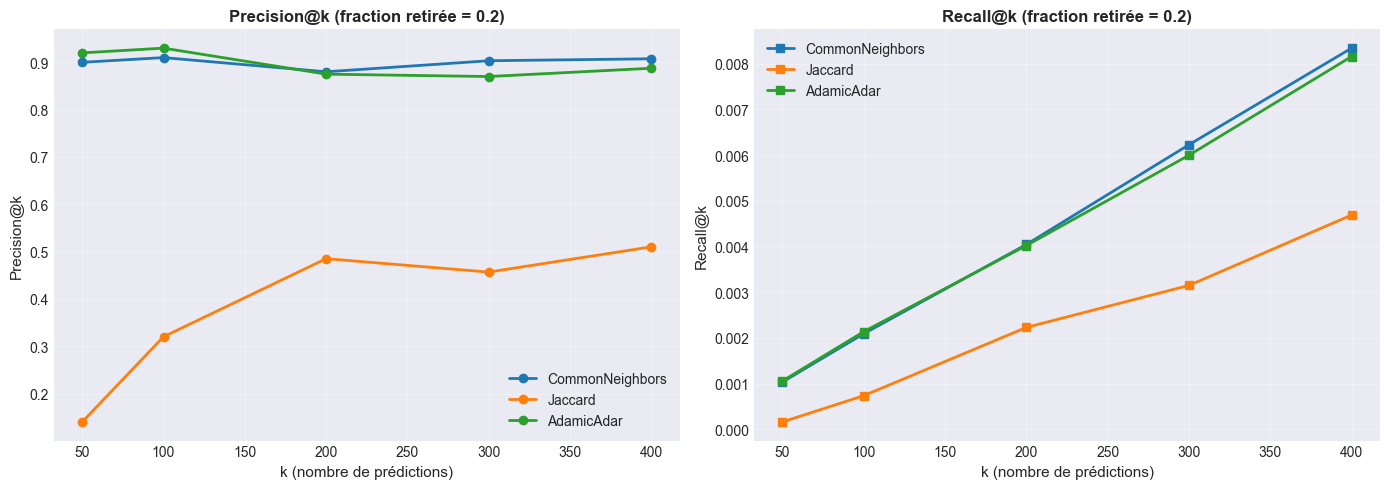


Résumé des performances moyennes sur toutes les fractions:
             metric    k  precision@k  recall@k
0        AdamicAdar   50     0.810000  0.001777
1        AdamicAdar  100     0.790000  0.003429
2        AdamicAdar  200     0.777500  0.006894
3        AdamicAdar  300     0.775833  0.010374
4        AdamicAdar  400     0.781250  0.013793
5   CommonNeighbors   50     0.820000  0.001832
6   CommonNeighbors  100     0.815000  0.003662
7   CommonNeighbors  200     0.790000  0.007011
8   CommonNeighbors  300     0.797500  0.010631
9   CommonNeighbors  400     0.790000  0.013962
10          Jaccard   50     0.165000  0.000366
11          Jaccard  100     0.275000  0.001122
12          Jaccard  200     0.398750  0.003333
13          Jaccard  300     0.435000  0.005672
14          Jaccard  400     0.423125  0.007152


In [12]:
# Visualisation des résultats de Link Prediction
if 'df_lp' in globals() and not df_lp.empty:
    print("Visualisation des résultats de Link Prediction\n")
    
    for f in sorted(df_lp['f_removed'].unique()):
        sub = df_lp[df_lp['f_removed'] == f]
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        for metric in sub['metric'].unique():
            s = sub[sub['metric'] == metric].sort_values('k')
            
            axes[0].plot(s['k'], s['precision@k'], marker='o', label=metric, linewidth=2)
            axes[1].plot(s['k'], s['recall@k'], marker='s', label=metric, linewidth=2)
        
        axes[0].set_title(f"Precision@k (fraction retirée = {f})", fontsize=12, fontweight='bold')
        axes[0].set_xlabel("k (nombre de prédictions)", fontsize=11)
        axes[0].set_ylabel("Precision@k", fontsize=11)
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        axes[1].set_title(f"Recall@k (fraction retirée = {f})", fontsize=12, fontweight='bold')
        axes[1].set_xlabel("k (nombre de prédictions)", fontsize=11)
        axes[1].set_ylabel("Recall@k", fontsize=11)
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Résumé des performances moyennes
    print("\nRésumé des performances moyennes sur toutes les fractions:")
    summary = df_lp.groupby(["metric","k"], as_index=False)[["precision@k","recall@k"]].mean()
    print(summary.to_string())
else:
    print("Aucun résultat de link prediction disponible")

## 5) Question 5 — Label Propagation (prédiction d'attributs manquants)

Implémentation d'un algorithme de **label propagation semi-supervisé**:
- On connaît les labels de certains nœuds (labeled)
- On propage l'information via la structure du graphe pour inférer les labels manquants

**Protocole d'évaluation:**
- Retirer aléatoirement 10%, 20%, 30% des labels connus
- Prédire ces labels avec l'algorithme de propagation
- Mesurer: accuracy, F1-score (macro), MAE

**Attributs évalués:** `dorm`, `major`, `gender`

In [13]:
def build_row_normalized_adjacency(G: nx.Graph):
    """Construit la matrice d'adjacence normalisée par ligne (format sparse PyTorch)"""
    n = G.number_of_nodes()
    edges = np.array(list(G.edges()), dtype=int)
    if len(edges) == 0:
        raise ValueError("Graphe sans arêtes")
    src = np.concatenate([edges[:,0], edges[:,1]])
    dst = np.concatenate([edges[:,1], edges[:,0]])
    idx = torch.tensor(np.vstack([src, dst]), dtype=torch.long)
    val = torch.ones(idx.shape[1], dtype=torch.float32)

    A = torch.sparse_coo_tensor(idx, val, size=(n, n))
    deg = torch.sparse.sum(A, dim=1).to_dense().clamp(min=1.0)
    inv_deg = 1.0 / deg
    val_norm = inv_deg[src]
    S = torch.sparse_coo_tensor(idx, val_norm, size=(n, n))
    return S


def label_propagation(G: nx.Graph, y: np.ndarray, mask_labeled: np.ndarray, 
                     alpha=0.9, max_iter=200, tol=1e-6, device="cpu"):
    """
    Algorithme de label propagation semi-supervisé
    
    Args:
        G: graphe NetworkX
        y: labels (-1 pour inconnu)
        mask_labeled: booléen indiquant les nœuds avec labels connus
        alpha: paramètre de mixage (0.9 = 90% voisins, 10% labels initiaux)
    """
    y = y.copy()
    n = len(y)
    classes = np.unique(y[mask_labeled])
    classes = classes[classes >= 0]
    C = int(classes.max() + 1)

    S = build_row_normalized_adjacency(G).to(device)

    Y = torch.zeros((n, C), dtype=torch.float32, device=device)
    for i in range(n):
        if mask_labeled[i] and y[i] >= 0:
            Y[i, y[i]] = 1.0

    F = Y.clone()

    for it in range(max_iter):
        F_new = alpha * torch.sparse.mm(S, F) + (1.0 - alpha) * Y
        F_new[mask_labeled] = Y[mask_labeled]
        delta = torch.norm(F_new - F).item()
        F = F_new
        if delta < tol:
            break

    y_pred = torch.argmax(F, dim=1).detach().cpu().numpy().astype(int)
    return y_pred


def get_node_attribute_array(G: nx.Graph, attr: str):
    """Extrait un attribut de nœud sous forme de tableau numpy"""
    n = G.number_of_nodes()
    attrs = nx.get_node_attributes(G, attr)
    y = -np.ones(n, dtype=int)
    for v, val in attrs.items():
        try:
            y[int(v)] = int(val)
        except Exception:
            pass
    return y


def evaluate_label_prop(G: nx.Graph, attr: str, frac_remove_list=(0.1,0.2,0.3), 
                       seed=0, device="cpu"):
    """Évalue la label propagation en retirant une fraction des labels"""
    rng = np.random.default_rng(seed)
    y_full = get_node_attribute_array(G, attr)
    known_idx = np.where(y_full >= 0)[0]

    if len(known_idx) < 50:
        raise ValueError(f"Pas assez de labels connus pour '{attr}' (n={len(known_idx)})")

    rows = []
    for frac in frac_remove_list:
        n_remove = int(frac * len(known_idx))
        removed_idx = rng.choice(known_idx, size=n_remove, replace=False)

        y_obs = y_full.copy()
        y_obs[removed_idx] = -1

        y_pred = label_propagation(G, y_obs, mask_labeled=(y_obs >= 0), device=device)

        y_true = y_full[removed_idx]
        y_hat = y_pred[removed_idx]

        acc = accuracy_score(y_true, y_hat)
        f1 = f1_score(y_true, y_hat, average="macro", zero_division=0)
        mae = float(np.mean(np.abs(y_true - y_hat)))

        rows.append({
            "attribut": attr,
            "fraction_retirée": frac,
            "n_test": len(removed_idx),
            "accuracy": acc,
            "f1_macro": f1,
            "mae": mae
        })

    return pd.DataFrame(rows)


# Sélection du graphe pour label propagation
G_lp_name = default_graph_name
G_lp = graphs[G_lp_name] if G_lp_name is not None else None
if G_lp is not None:
    print(f"Graphe sélectionné pour Label Propagation: {G_lp_name}")
    print(f"{G_lp.number_of_nodes()} nœuds, {G_lp.number_of_edges()} arêtes")
else:
    print("Aucun graphe disponible")

Graphe sélectionné pour Label Propagation: American75
6370 nœuds, 217654 arêtes


In [14]:
# Évaluation de label propagation pour dorm, major, gender
if G_lp is not None:
    print("Évaluation de Label Propagation...\n")
    results_lp = []
    
    for attr in ["dorm", "major", "gender"]:
        try:
            print(f"Traitement de l'attribut '{attr}'...")
            df_attr = evaluate_label_prop(G_lp, attr, frac_remove_list=(0.1,0.2,0.3), 
                                         seed=0, device="cpu")
            results_lp.append(df_attr)
            print(f"  ✓ Terminé")
        except Exception as e:
            print(f"  ✗ Échec: {e}")

    if results_lp:
        df_lp_labels = pd.concat(results_lp, ignore_index=True)
        print("\nRésultats de Label Propagation:")
        print(df_lp_labels.to_string())
        
        # Visualisation
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        metrics = ['accuracy', 'f1_macro', 'mae']
        titles = ['Accuracy', 'F1-Score (macro)', 'MAE']
        
        for idx, (metric, title) in enumerate(zip(metrics, titles)):
            for attr in df_lp_labels['attribut'].unique():
                sub = df_lp_labels[df_lp_labels['attribut'] == attr]
                axes[idx].plot(sub['fraction_retirée'], sub[metric], 
                             marker='o', label=attr, linewidth=2)
            
            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].set_xlabel("Fraction de labels retirés", fontsize=11)
            axes[idx].set_ylabel(title, fontsize=11)
            axes[idx].legend()
            axes[idx].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Aucun résultat disponible")
else:
    print("Aucun graphe disponible pour l'évaluation")

Évaluation de Label Propagation...

Traitement de l'attribut 'dorm'...
  ✗ Échec: index 6378 is out of bounds for dimension 0 with size 6370
Traitement de l'attribut 'major'...
  ✗ Échec: Pas assez de labels connus pour 'major' (n=0)
Traitement de l'attribut 'gender'...
  ✗ Échec: index 6378 is out of bounds for dimension 0 with size 6370
Traitement de l'attribut 'major'...
  ✗ Échec: Pas assez de labels connus pour 'major' (n=0)
Traitement de l'attribut 'gender'...
  ✗ Échec: index 6378 is out of bounds for dimension 0 with size 6370
Aucun résultat disponible
  ✗ Échec: index 6378 is out of bounds for dimension 0 with size 6370
Aucun résultat disponible


## 6) Question 6 — Détection de communautés (question de recherche)

**Démarche:**
1. Proposer une **hypothèse de recherche** sur la formation de groupes
2. Choisir une ou plusieurs universités pour tester l'hypothèse
3. Appliquer une méthode de détection de communautés
4. Analyser la correspondance avec les attributs (dorm, major, year, gender)
5. Conclure

**Exemples d'hypothèses:**
- Les communautés détectées reflètent principalement la **résidence (dorm)**
- Les communautés reflètent davantage l'**année (year)** que le major
- La structure communautaire diffère entre petites et grandes universités

**Métriques de comparaison:**
- NMI (Normalized Mutual Information): mesure l'information partagée
- ARI (Adjusted Rand Index): mesure l'accord entre deux partitions

Détection de communautés sur: American75
6370 nœuds, 217654 arêtes


Algorithmes appliqués: ['Louvain', 'Greedy Modularity']

Louvain: 13 communautés détectées

Greedy Modularity: 19 communautés détectées

Algorithmes appliqués: ['Louvain', 'Greedy Modularity']

Louvain: 13 communautés détectées

Greedy Modularity: 19 communautés détectées

Comparaison communautés vs attributs:
             méthode  n_communautés attribut  n_évalués       NMI       ARI
3  Greedy Modularity             19     dorm       6354  0.014176  0.002741
4  Greedy Modularity             19   gender       6354  0.002638 -0.001414
5  Greedy Modularity             19     year       6354  0.016569  0.005347
0            Louvain             13     dorm       6354  0.019215 -0.003688
1            Louvain             13   gender       6354  0.001047  0.001843
2            Louvain             13     year       6354  0.013165  0.007606

Comparaison communautés vs attributs:
             méthode  n_communautés attribut  n_

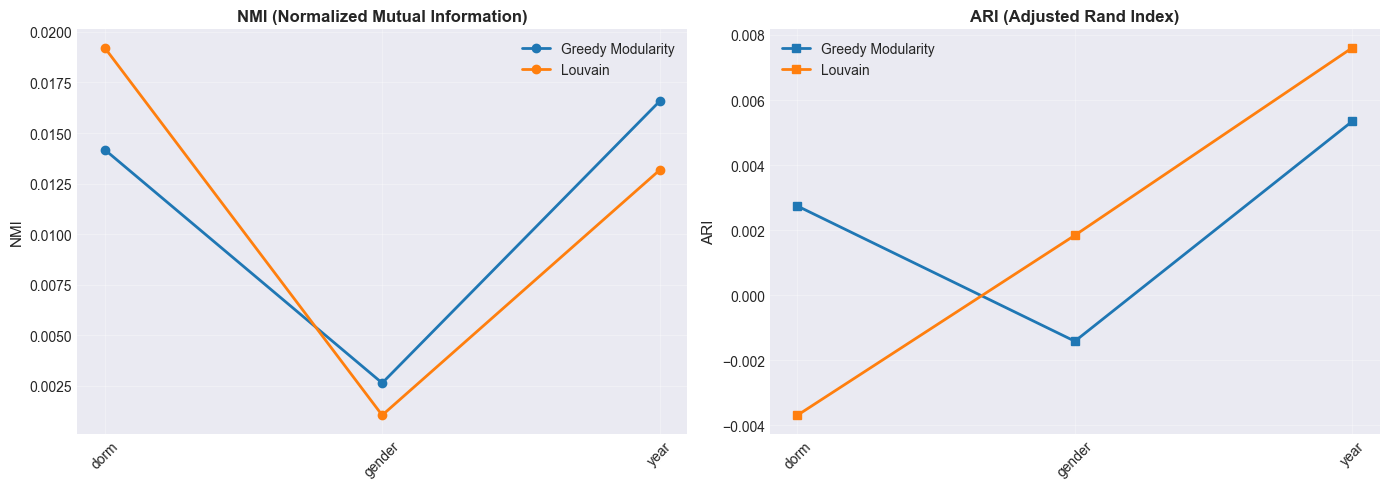

In [16]:
def run_community_detection(G: nx.Graph):
    """Applique plusieurs algorithmes de détection de communautés"""
    out = {}
    
    # Louvain (si disponible)
    try:
        comms = nx.algorithms.community.louvain_communities(G, seed=0)
        out["Louvain"] = comms
    except Exception as e:
        print(f"[INFO] Louvain indisponible: {e}")

    # Greedy Modularity
    try:
        comms2 = nx.algorithms.community.greedy_modularity_communities(G)
        out["Greedy Modularity"] = list(comms2)
    except Exception as e:
        print(f"[INFO] Greedy Modularity échec: {e}")
    
    return out


def communities_to_labels(comms, G):
    """Convertit une liste de communautés en tableau de labels"""
    n = G.number_of_nodes()
    labels = -np.ones(n, dtype=int)
    
    # Créer un mapping nœud -> index
    node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}
    
    for c_id, c in enumerate(comms):
        for v in c:
            idx = node_to_idx.get(v)
            if idx is not None:
                labels[idx] = c_id
    return labels


def compare_communities_with_attribute(G: nx.Graph, comm_labels: np.ndarray, attr: str):
    """Compare les communautés détectées avec un attribut de nœud"""
    y = get_node_attribute_array(G, attr)
    idx = np.where((y >= 0) & (comm_labels >= 0))[0]
    
    if len(idx) < 50:
        return None
    
    nmi = normalized_mutual_info_score(y[idx], comm_labels[idx])
    ari = adjusted_rand_score(y[idx], comm_labels[idx])
    
    return {
        "attribut": attr, 
        "n_évalués": len(idx), 
        "NMI": nmi, 
        "ARI": ari
    }


# Sélection du graphe pour détection de communautés
G_comm_name = default_graph_name
G_comm = graphs[G_comm_name] if G_comm_name is not None else None

if G_comm is not None:
    print(f"Détection de communautés sur: {G_comm_name}")
    print(f"{G_comm.number_of_nodes()} nœuds, {G_comm.number_of_edges()} arêtes\n")
    
    comms_dict = run_community_detection(G_comm)
    print(f"\nAlgorithmes appliqués: {list(comms_dict.keys())}")
    
    rows = []
    for method, comms in comms_dict.items():
        labels = communities_to_labels(comms, G_comm)
        n_comms = len(comms)
        print(f"\n{method}: {n_comms} communautés détectées")
        
        for attr in ["dorm", "major", "gender", "year"]:
            res = compare_communities_with_attribute(G_comm, labels, attr)
            if res is not None:
                rows.append({"méthode": method, "n_communautés": n_comms, **res})

    if rows:
        df_comm = pd.DataFrame(rows).sort_values(["méthode","attribut"])
        print("\nComparaison communautés vs attributs:")
        print(df_comm.to_string())
        
        # Visualisation
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        for method in df_comm['méthode'].unique():
            sub = df_comm[df_comm['méthode'] == method]
            axes[0].plot(range(len(sub)), sub['NMI'], marker='o', label=method, linewidth=2)
            axes[1].plot(range(len(sub)), sub['ARI'], marker='s', label=method, linewidth=2)
        
        axes[0].set_xticks(range(len(sub)))
        axes[0].set_xticklabels(sub['attribut'], rotation=45)
        axes[0].set_title("NMI (Normalized Mutual Information)", fontsize=12, fontweight='bold')
        axes[0].set_ylabel("NMI", fontsize=11)
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        axes[1].set_xticks(range(len(sub)))
        axes[1].set_xticklabels(sub['attribut'], rotation=45)
        axes[1].set_title("ARI (Adjusted Rand Index)", fontsize=12, fontweight='bold')
        axes[1].set_ylabel("ARI", fontsize=11)
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Aucune comparaison disponible")
else:
    print("Aucun graphe disponible")

## 7) Production du rapport final

**Ce qu'il faut inclure dans votre rendu PDF/DOCX:**

### Question 2 (Analyse des réseaux)
- Figures: distributions de degrés (histogramme + CCDF) pour les 3 universités
- Tableau: métriques de clustering et densité
- Figure: degré vs clustering local
- **Interprétation**: hétérogénéité des degrés, sparsité, clustering élevé typique des réseaux sociaux

### Question 3 (Assortativité)
- Figures: scatter assortativité vs taille pour les 5 attributs
- Histogrammes des distributions d'assortativité
- **Interprétation**: homophilie par attribut, dépendance à la taille du réseau

### Question 4 (Link Prediction)
- Courbes: precision@k et recall@k pour chaque méthode
- Tableau: performances moyennes
- **Interprétation**: comparaison des métriques (CN, Jaccard, Adamic/Adar)

### Question 5 (Label Propagation)
- Courbes: accuracy, F1, MAE vs fraction retirée
- **Interprétation**: quels attributs sont mieux prédits et pourquoi (signal structurel, nombre de classes)

### Question 6 (Communautés)
- **Hypothèse de recherche** clairement énoncée
- Résultats: NMI et ARI pour différents attributs
- **Conclusion**: validation ou réfutation de l'hypothèse

**N'oubliez pas:**
- Code source dans GitHub classroom
- Figures de qualité (lisibles, avec légendes)
- Texte explicatif pour chaque question